<a href="https://colab.research.google.com/github/vtecftwy/utseus-dives/blob/main/nbs/dive_1_2_tabular_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Working with structured data - tabular data

In [ ]:
try:
    from dtreeviz import __version__
except ModuleNotFoundError:
    !pip install -Uqq dtreeviz

In [ ]:
from fastai.data.external import untar_data
from fastai.tabular.all import *
from IPython.display import Image, display_svg, SVG
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import warnings

warnings.filterwarnings('ignore')
pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

## Introduction

In this notebook, we will look at several machine learning techniques used to make prediction on tabular data.

1. Ensembles of decision trees (i.e. random forests which we will use or gradient boosting machines), are the go-to techniques for tabular data. They are fast and handle large data sets. They are computing efficient. In addition, then provide intuitive explainability. We will see these aspects in this notebook.
1. Multilayered neural networks (a.k.a. Multilayered Perceptrons) may also be used for structured data. However, they are only required when used in conbination with unstructured data (such as audio, images, and natural language).

We will use the **scikit-learn** (also known as `sklearn`) library to implement decision tree and ensemble techniques.

Scikit-learn is a very popular library for creating machine learning models, with most techniques other than deep learning. Scikit-learn also provides tools for data processing and model evaluation.

Tabular data processing is best done with the **Pandas** library, which is best fit to handle two dimension data arrays with multiple data types, like the data we are facing. We will also need **NumPy**, which is numeric programming library that both sklearn and Pandas rely on.

## The Data: Pricing for second hand bulldozers

The dataset we will use comes from the Kaggle competition: "Blue Book for Bulldozers". The competition description notes: "The goal of the contest is to **predict the sale price** of a particular piece of heavy equipment at auction **based on its usage, equipment type, and configuration**.  The data is sourced from auction result postings and includes information on usage and equipment configurations."

This is a very typical dataset and prediction problem you would face in a real project or at work.

#### Loading dataset

First we download the dataset, using the `untar_data` utility function provided by `fastai`. It will download the data and return the path of the directory where it is saved.

In [ ]:
path = untar_data('https://diyai-dives.s3.ap-southeast-1.amazonaws.com/datasets/bluebook-for-bulldozers.zip')
path

Path('/root/.fastai/data/bluebook-for-bulldozers')

Let's review the files we have downloaded. The key file is **`TrainAndValid.csv`**

In [ ]:
data_files = [p.name for p in path.ls() if 'csv' in p.name or 'xls' in p.name]
for p in data_files:
    print(p)

Valid.csv
Data Dictionary.xlsx
TrainAndValid.csv
Machine_Appendix.csv
ValidSolution.csv
median_benchmark.csv
random_forest_benchmark_test.csv
Test.csv


### Look at the Data

The dataset includes a file with a description of all variables (`Data Dictionary.xlsx`). Including:

- `SalesID`:: The unique identifier of the sale.
- `MachineID`:: The unique identifier of a machine.  A machine can be sold multiple times.
- `saleprice`:: What the machine sold for at auction (only provided in *train.csv*).
- `saledate`:: The date of the sale.

To see a description of all variables, click below.

<details>
<summary><b>Click here to see a description of all variables in the dataset</b></summary>
<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
</style>
<table class="tg"><thead>
  <tr>
    <th class="tg-0pky">Variable</th>
    <th class="tg-0pky">Description</th>
    <th class="tg-0pky"></th>
    <th class="tg-0pky"></th>
    <th class="tg-0pky"></th>
  </tr></thead>
<tbody>
  <tr>
    <td class="tg-0pky">SalesID</td>
    <td class="tg-0pky">  unique identifier of a particular sale of amachine at auction</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">MachineID</td>
    <td class="tg-0pky">  identifier for a particular machine;  machines may have multiple sales</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">ModelID</td>
    <td class="tg-0pky">  identifier for a unique machine model (i.e.fiModelDesc)</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">datasource</td>
    <td class="tg-0pky">  source of the sale record;  some sources are more diligent aboutreporting attributes of the machine than others.  Note that a particular datasource mayreport on multiple auctioneerIDs.</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">auctioneerID</td>
    <td class="tg-0pky">  identifier of a particular auctioneer, i.e.company that sold the machine at auction. Not the same as datasource.</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">YearMade</td>
    <td class="tg-0pky">  year of manufacturer of the Machine</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">MachineHoursCurrentMeter</td>
    <td class="tg-0pky">  current usage of the machine in hours attime of sale (saledate);  null or 0means no hours have been reported for that sale</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">UsageBand</td>
    <td class="tg-0pky">  value (low, medium, high) calculatedcomparing this particular Machine-Sale hours to average usage for thefiBaseModel;  e.g. 'Low' means thismachine has less hours given it's lifespan relative to average offiBaseModel.</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">Saledate</td>
    <td class="tg-0pky">  time of sale</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">Saleprice</td>
    <td class="tg-0pky">  cost of sale in USD</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">fiModelDesc</td>
    <td class="tg-0pky">  Description of a unique machine model (seeModelID); concatenation of fiBaseModel &amp;amp; fiSecondaryDesc &amp;amp;fiModelSeries &amp;amp; fiModelDescriptor</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">fiBaseModel</td>
    <td class="tg-0pky">  disaggregation of fiModelDesc</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">fiSecondaryDesc</td>
    <td class="tg-0pky">  disaggregation of fiModelDesc</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">fiModelSeries</td>
    <td class="tg-0pky">  disaggregation of fiModelDesc</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">fiModelDescriptor</td>
    <td class="tg-0pky">  disaggregation of fiModelDesc</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">ProductSize</td>
    <td class="tg-0pky">  Don't know what this is </td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">ProductClassDesc</td>
    <td class="tg-0pky">  description of 2nd level hierarchicalgrouping (below ProductGroup) of fiModelDesc</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">State</td>
    <td class="tg-0pky">  US State in which sale occurred</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">ProductGroup</td>
    <td class="tg-0pky">  identifier for top-level hierarchicalgrouping of fiModelDesc</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">ProductGroupDesc</td>
    <td class="tg-0pky">  description of top-level hierarchicalgrouping of fiModelDesc</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">Drive_System</td>
    <td class="tg-0pky">machineconfiguration;  typcially describeswhether 2 or 4 wheel drive</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">Enclosure</td>
    <td class="tg-0pky">machineconfiguration - does machine have an enclosed cab or not</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">Forks</td>
    <td class="tg-0pky">machineconfiguration - attachment used for lifting</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">Pad_Type</td>
    <td class="tg-0pky">machineconfiguration - type of treads a crawler machine uses</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">Ride_Control</td>
    <td class="tg-0pky">machineconfiguration - optional feature on loaders to make the ride smoother</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">Stick</td>
    <td class="tg-0pky">machineconfiguration - type of control </td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">Transmission</td>
    <td class="tg-0pky">machineconfiguration - describes type of transmission;  typically automatic or manual</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">Turbocharged</td>
    <td class="tg-0pky">machineconfiguration - engine naturally aspirated or turbocharged</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">Blade_Extension</td>
    <td class="tg-0pky">machineconfiguration - extension of standard blade</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">Blade_Width</td>
    <td class="tg-0pky">machineconfiguration - width of blade</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">Enclosure_Type</td>
    <td class="tg-0pky">machineconfiguration - does machine have an enclosed cab or not</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">Engine_Horsepower</td>
    <td class="tg-0pky">machineconfiguration - engine horsepower rating</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">Hydraulics</td>
    <td class="tg-0pky">machineconfiguration - type of hydraulics</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">Pushblock</td>
    <td class="tg-0pky">machineconfiguration - option</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">Ripper</td>
    <td class="tg-0pky">machineconfiguration - implement attached to machine to till soil</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">Scarifier</td>
    <td class="tg-0pky">machineconfiguration - implement attached to machine to condition soil</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">Tip_control</td>
    <td class="tg-0pky">machineconfiguration - type of blade control</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">Tire_Size</td>
    <td class="tg-0pky">machineconfiguration - size of primary tires</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">Coupler</td>
    <td class="tg-0pky">machineconfiguration - type of implement interface</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">Coupler_System</td>
    <td class="tg-0pky">machineconfiguration - type of implement interface</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">Grouser_Tracks</td>
    <td class="tg-0pky">machineconfiguration - describes ground contact interface</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">Hydraulics_Flow</td>
    <td class="tg-0pky">machineconfiguration - normal or high flow hydraulic system</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">Track_Type</td>
    <td class="tg-0pky">machineconfiguration - type of treads a crawler machine uses</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">Undercarriage_Pad_Width</td>
    <td class="tg-0pky">machineconfiguration - width of crawler treads</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">Stick_Length</td>
    <td class="tg-0pky">machineconfiguration - length of machine digging implement</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">Thumb</td>
    <td class="tg-0pky">machineconfiguration - attachment used for grabbing</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">Pattern_Changer</td>
    <td class="tg-0pky">machineconfiguration - can adjust the operator control configuration to suit theuser</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">Grouser_Type</td>
    <td class="tg-0pky">machineconfiguration - type of treads a crawler machine uses</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">Backhoe_Mounting</td>
    <td class="tg-0pky">machineconfiguration - optional interface used to add a backhoe attachment</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">Blade_Type</td>
    <td class="tg-0pky">machineconfiguration - describes type of blade</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">Travel_Controls</td>
    <td class="tg-0pky">machineconfiguration - describes operator control configuration</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">Differential_Type</td>
    <td class="tg-0pky">machineconfiguration - differential type, typically locking or standard</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">Steering_Controls</td>
    <td class="tg-0pky">machineconfiguration - describes operator control configuration</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
</tbody></table>
</details>

The first step in working with tabular data is to look at your data directly, and ensure that you understand the format, how it is structured, what types of values it holds ...

Even if you have read the descriptions, the actual data may not be what you expect.

First we load the training dataset into a Pandas DataFrame.

Let's load our data and have a look at the shape (nbr of rows and nbr of columns), then the list of columns:

In [ ]:
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df.shape

(412698, 53)

In [ ]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

We have a lot of columns. We can specify a sublist of columns we want to look at, specificaly, and only show these.

In [ ]:
prod_descriptions = ['ProductGroup', 'ProductGroupDesc', 'fiProductClassDesc', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor']
df.loc[:, prod_descriptions].sample(10)

,ProductGroup,ProductGroupDesc,fiProductClassDesc,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor
313847,TTT,Track Type Tractors,"Track Type Tractor, Dozer - 85.0 to 105.0 Horsepower",D4HIILGP,D4,H,II,LGP
302218,MG,Motor Graders,Motorgrader - 170.0 to 200.0 Horsepower,140H,140,H,NaN,NaN
200467,BL,Backhoe Loaders,Backhoe Loader - 15.0 to 16.0 Ft Standard Digging Depth,410G,410,G,NaN,NaN
383541,TTT,Track Type Tractors,"Track Type Tractor, Dozer - 85.0 to 105.0 Horsepower",D5GLGP,D5,G,NaN,LGP
3468,TEX,Track Excavators,"Hydraulic Excavator, Track - 33.0 to 40.0 Metric Tons",SE350LC-2,SE350,LC,-2,NaN
128202,WL,Wheel Loader,Wheel Loader - 150.0 to 175.0 Horsepower,950,950,NaN,NaN,NaN
176430,WL,Wheel Loader,Wheel Loader - 175.0 to 200.0 Horsepower,644G,644,G,NaN,NaN
319226,TTT,Track Type Tractors,"Track Type Tractor, Dozer - 20.0 to 75.0 Horsepower",D3G,D3,G,NaN,NaN
66194,WL,Wheel Loader,Wheel Loader - 90.0 to 100.0 Horsepower,916,916,NaN,NaN,NaN
215696,TEX,Track Excavators,"Hydraulic Excavator, Track - 0.0 to 2.0 Metric Tons",ZX17U-2,ZX17,U,-2,NaN


It is good practice to look through the dataset to get a sense of what kind of information is in each column. We would also normally perform an in depth exploratory data analysis (variable range, distributions, outliers, ...).

In this notebook, we will focus on a few of the most interesting bits only.

### Identify ordinal data

It is a good idea to handle *ordinal data*. That is columns containing strings or similar, but where those strings have a **natural ordering**.



In [ ]:
for col in df.columns:
    feature = df.loc[:, col]
    uniques = feature.unique()
    if 2 < len(uniques) < 10 and feature.dtype == 'O':
        print(f' - {col}: {uniques}', '\n')

 - UsageBand: ['Low' 'High' 'Medium' nan] 

 - ProductSize: [nan 'Medium' 'Small' 'Large / Medium' 'Mini' 'Large' 'Compact'] 

 - ProductGroup: ['WL' 'SSL' 'TEX' 'BL' 'TTT' 'MG'] 

 - ProductGroupDesc: ['Wheel Loader' 'Skid Steer Loaders' 'Track Excavators' 'Backhoe Loaders'
 'Track Type Tractors' 'Motor Graders'] 

 - Drive_System: [nan 'Four Wheel Drive' 'Two Wheel Drive' 'No' 'All Wheel Drive'] 

 - Enclosure: ['EROPS w AC' 'OROPS' 'EROPS' nan 'EROPS AC' 'NO ROPS'
 'None or Unspecified'] 

 - Forks: ['None or Unspecified' nan 'Yes'] 

 - Pad_Type: [nan 'None or Unspecified' 'Reversible' 'Street' 'Grouser'] 

 - Ride_Control: ['None or Unspecified' nan 'No' 'Yes'] 

 - Stick: [nan 'Extended' 'Standard'] 

 - Transmission: [nan 'Powershuttle' 'Standard' 'Powershift' 'None or Unspecified'
 'Hydrostatic' 'Autoshift' 'Direct Drive' 'AutoShift'] 

 - Turbocharged: [nan 'None or Unspecified' 'Yes'] 

 - Blade_Extension: [nan 'Yes' 'None or Unspecified'] 

 - Blade_Width: [nan 'None or Unsp

For instance, here are the levels of `ProductSize`:

In [ ]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large',
       'Compact'], dtype=object)

You can tell Pandas about a suitable ordering of these levels like so:

In [ ]:
sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'] = df['ProductSize'].cat.set_categories(sizes, ordered=True)

Same for `UsageBand`

In [ ]:
usages = 'High', 'Medium', 'Low'
df['UsageBand'] = df['UsageBand'].astype('category')
df['UsageBand'] = df['UsageBand'].cat.set_categories(usages, ordered=True)
df['UsageBand'].dtype

CategoricalDtype(categories=['High', 'Medium', 'Low'], ordered=True)

### Dependant variable - also called the target

The most important data column is the **dependent variable**—that is, the one we want to predict. This variable requires additional review.

We normally select a metric for our problem after analysing what type of error we want to avoid. Is an important part of a project setup. In our case, Kaggle tells us what metric to use: **root mean squared log error (RMSLE)** between the actual and predicted auction prices.

We will therefore need to do some processing to use it: we will take the **`log`** of the prices, so that **`rmse`** of that value will give us what we ultimately need.

In [ ]:
dep_var = 'SalePrice'

In [ ]:
df[dep_var] = np.log(df[dep_var])

### Handling Dates

When the dataset includes dates such as `Saledate`, it is good practive to enrich the dataset with engineered features related to that date: day of the week, month of the year, ....

**Why is this important?**

Decision trees work by successive binary decisions (go left or go right) to devide dividing a group of data into two.

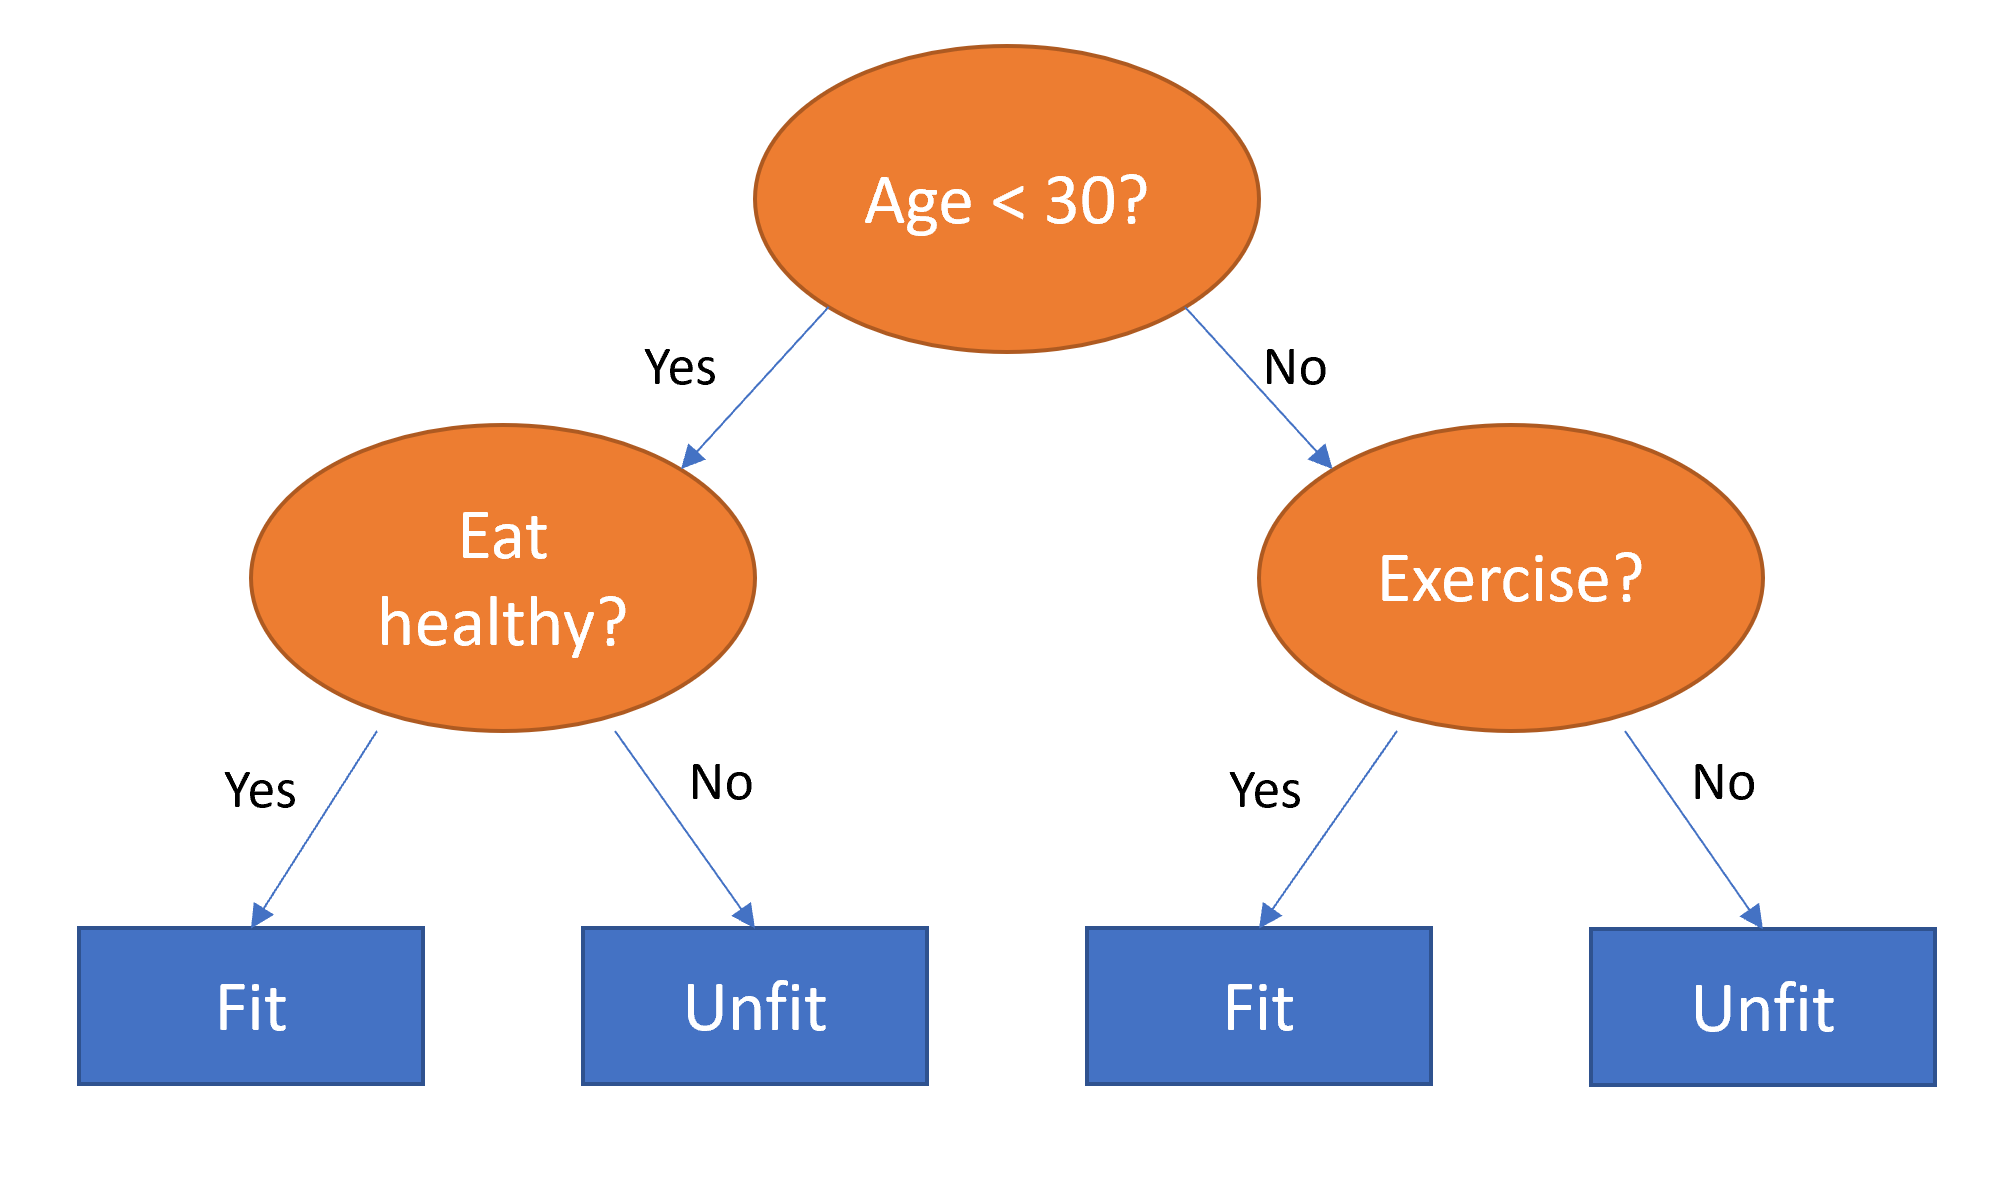

For **numerical** and **ordinal data**, this decision is straihforward. For **categorical** data, it is also easy once they are one-hot-encoded.

**But how does this apply to dates?**

If we treat the date as a timestamp and split along the time, we loose a lot of the meaning in a date. For instance, it will not make a decision based on the day of the week.

We need to help our decision tree algorithm handle dates intelligently, by adding variavle allowing for such decisions, beyond the mere fact whether a date is more recent or less recent than another.

We could create variavle so that the decision tree can make decisions based on that date's day of the week, on whether a day is a holiday, on what month it is in, and so forth. To do this, we replace every date column with a set of date metadata columns, such as holiday, day of week, and month. These columns provide categorical data that we suspect will be useful.

`fastai` comes with a function that will do this for us—we just have to pass a column name that contains dates. It will replace the date column by a set of other columns.

In [ ]:
from fastai.tabular.all import add_datepart

In [ ]:
df = add_datepart(df, 'saledate')

In [ ]:
' '.join(f for f in df.columns if f.startswith('sale'))

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

In [ ]:
df.loc[:,[f for f in df.columns if f.startswith('sale')]].sample(5).T

,270678,182626,107877,336094,312431
saleYear,2008,2005,2001,2008,2009
saleMonth,2,8,10,1,5
saleWeek,9,35,42,2,22
saleDay,26,31,16,12,27
saleDayofweek,1,2,1,5,2
saleDayofyear,57,243,289,12,147
saleIs_month_end,False,True,False,False,False
saleIs_month_start,False,False,False,False,False
saleIs_quarter_end,False,False,False,False,False
saleIs_quarter_start,False,False,False,False,False


Let's do the same for the test set while we're there:

In [ ]:
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

We can see that there are now lots of new columns in our DataFrame:

This is a good first step, but we will need to do a bit more cleaning. For this, we will use fastai objects called `TabularPandas` and `TabularProc`.

### Handling categorical data and missing data

Another pre-processing required is handling strings and missing data.

`sklearn` cannot do either out of the box, it requires the use of powerful data preprocessing classes, which are out of the scope of this notebook.

Instead we will use two `fastai` classes:
- `TabularPandas`, which wraps a Pandas DataFrame and provides a few additional conveniences.
- `TabularProc`, preprocessing transform function (e.g. `Categorify` and `FillMissing`) which will be used to process data before loading them into `TabularPandas`.
    - `Categorify` is a `TabularProc` that replaces a column with a numeric categorical column.
    - `FillMissing` is a `TabularProc` that replaces missing values with the median of the column, and creates a new Boolean column that is set to `True` for any row where the value was missing.
    
These two transforms are needed for nearly every tabular dataset you will use, so this is a good starting point for your data processing:

First we defince a "pipeline", i.e. that list of the transforms we want to apply to our data.

In [ ]:
procs = [Categorify, FillMissing]

`TabularPandas` will also handle splitting the dataset into **training** and **validation** sets for us.

However we need to be very careful about our validation set because we have a time element. We want to design it so that we do not bring data from the future into the training dataset and data from the past in the validation dataset.

<details>
<summary>More on training, validation and test sets</summary>
<p>Recall the distinction between a validation set and a test set, as discussed in `Chapter 1 Intro`. A validation set is data we hold back from training in order to ensure that the training process does not overfit on the training data. A test set is data that is held back even more deeply, from us ourselves, in order to ensure that *we* don't overfit on the validation data, as we explore various model architectures and hyperparameters.</p>
<p>With a Kaggle competition, we don't get to see the test set. But we do want to define our validation data so that it has the same sort of relationship to the training data as the test set will have.</p>
<p>In some cases, just randomly choosing a subset of your data points will do that. This is not one of those cases, because it is a time series.</p>
<p>If you look at the date range represented in the test set, you will discover that it covers a six-month period from May 2012, which is later in time than any date in the training set. This is a good design, because the competition sponsor will want to ensure that a model is able to predict the future. But it means that if we are going to have a useful validation set, we also want the validation set to be later in time than the training set. The Kaggle training data ends in April 2012, so we will define a narrower training dataset which consists only of the Kaggle training data from before November 2011, and we'll define a validation set consisting of data from after November 2011.</p>
</details>


You can read the note the training and validation sets, of just run the next cell where we use `np.where`, to split early and late data points:

In [ ]:
condition = (df.saleYear < 2011) | (df.saleMonth < 10)
train_idx = np.where( condition)[0]
valid_idx = np.where(~condition)[0]

splits = (list(train_idx),list(valid_idx))
print(f"{len(train_idx):,d} training samples and {len(valid_idx):,d} validation samples")

404,710 training samples and 7,988 validation samples


`TabularPandas` needs to be told which columns are **continuous** and which are **categorical**. We can handle that automatically using the helper function `cont_cat_split`:

In [ ]:
from fastai.tabular.all import cont_cat_split
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)

In [ ]:
', '.join(cont)

'SalesID, MachineID, ModelID, datasource, auctioneerID, YearMade, MachineHoursCurrentMeter, saleYear, saleMonth, saleWeek, saleDay, saleDayofweek, saleDayofyear, saleElapsed'

In [ ]:
', '.join(cat)

'UsageBand, fiModelDesc, fiBaseModel, fiSecondaryDesc, fiModelSeries, fiModelDescriptor, ProductSize, fiProductClassDesc, state, ProductGroup, ProductGroupDesc, Drive_System, Enclosure, Forks, Pad_Type, Ride_Control, Stick, Transmission, Turbocharged, Blade_Extension, Blade_Width, Enclosure_Type, Engine_Horsepower, Hydraulics, Pushblock, Ripper, Scarifier, Tip_Control, Tire_Size, Coupler, Coupler_System, Grouser_Tracks, Hydraulics_Flow, Track_Type, Undercarriage_Pad_Width, Stick_Length, Thumb, Pattern_Changer, Grouser_Type, Backhoe_Mounting, Blade_Type, Travel_Controls, Differential_Type, Steering_Controls, saleIs_month_end, saleIs_month_start, saleIs_quarter_end, saleIs_quarter_start, saleIs_year_end, saleIs_year_start'

In [ ]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

A `TabularPandas` behaves a lot like a fastai `Datasets` object, including providing `train` and `valid` attributes:

In [ ]:
len(to.train),len(to.valid)

(404710, 7988)

Even though categorical data are encoded, `TabularPandas` still displays them as strings, because in automatically "decodes" it.

In [ ]:
to1 = TabularPandas(df, procs, ['state', 'ProductGroup', 'Drive_System', 'Enclosure'], [], y_names=dep_var, splits=splits)
to1.show(3)

,state,ProductGroup,Drive_System,Enclosure,SalePrice
0,Alabama,WL,#na#,EROPS w AC,11.097410
1,North Carolina,WL,#na#,EROPS w AC,10.950807
2,New York,SSL,#na#,OROPS,9.210340


However, the underlying items are all numeric:

In [ ]:
to1.items.loc[:, ['state', 'ProductGroup', 'Drive_System', 'Enclosure']].head(3)

,state,ProductGroup,Drive_System,Enclosure
0,1,6,0,3
1,33,6,0,3
2,32,3,0,6


The conversion of categorical columns to numbers is done by simply replacing each unique level with a number. The numbers associated with the levels are chosen consecutively as they are seen in a column, so there's no particular meaning to the numbers in categorical columns after conversion. The exception is if you first convert a column to a Pandas ordered category (as we did for `ProductSize` earlier), in which case the ordering you chose is used. We can see the mapping by looking at the `classes` attribute:

In [ ]:
to.classes['ProductSize'], to.classes['UsageBand']

(['#na#', 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact'],
 ['#na#', 'High', 'Medium', 'Low'])

`TabularPandas` also wraps both the training and the validating dataset:

In [ ]:
to.train.show(3)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1.163635e+09,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1.080259e+09,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,9,26,3,57,1.077754e+09,9.210340


In [ ]:
to.valid.show(3)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
22915,Low,D6D,D6,D,#na#,#na#,Medium,"Track Type Tractor, Dozer - 130.0 to 160.0 Horsepower",Minnesota,TTT,Track Type Tractors,#na#,EROPS,#na#,#na#,#na#,#na#,Powershift,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,Lever,#na#,#na#,False,False,False,False,False,False,False,False,1218822,1024652,4124,121,3.0,1000,6240.0,2011,10,40,3,0,276,1.317600e+09,10.043249
22916,Medium,214E4WD,214,E,#na#,4WD,#na#,Backhoe Loader - 14.0 to 15.0 Ft Standard Digging Depth,Virginia,BL,Backhoe Loaders,Four Wheel Drive,OROPS,None or Unspecified,None or Unspecified,No,Extended,Standard,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1218823,1067601,24808,121,3.0,2006,1802.0,2011,10,40,6,3,279,1.317859e+09,10.085809
22917,Medium,T190,T190,#na#,#na#,#na#,#na#,Skid Steer Loader - 1751.0 to 2201.0 Lb Operating Capacity,Virginia,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,Manual,Yes,Yes,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1218824,1010582,9580,121,3.0,2006,1926.0,2011,10,40,6,3,279,1.317859e+09,9.392662


Basic pandas functions are swtill accessible to `TabularPandas` objects:

In [ ]:
to.loc[:,:].head(3)

,SalesID,SalePrice,MachineID,ModelID,...,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,3157,...,1,1.163635e+09,1,1
1,1139248,10.950807,117657,77,...,1,1.080259e+09,1,1
2,1139249,9.210340,434808,7009,...,1,1.077754e+09,1,1


In [ ]:
to.items.head(3)

,SalesID,SalePrice,MachineID,ModelID,...,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,3157,...,1,1.163635e+09,1,1
1,1139248,10.950807,117657,77,...,1,1.080259e+09,1,1
2,1139249,9.210340,434808,7009,...,1,1.077754e+09,1,1


Since it takes a minute or so to process the data to get to this point, we should save it—that way in the future we can continue our work from here without rerunning the previous steps. fastai provides a `save` method that uses Python's *pickle* system to save nearly any Python object:

In [ ]:
save_pickle(path/'to.pkl',to)

To read this back later, you would type:

```python
to = (path/'to.pkl').load()
```

Now that all this preprocessing is done, we are ready to create a decision tree.

## Creating a Decision Tree

To begin, we define our independent and dependent variables:

In [ ]:
to = load_pickle(path/'to.pkl')

In [ ]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

Now that our data is all numeric, and there are no missing values, we can create a decision tree:

In [ ]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);

To keep it simple, we've told sklearn to just create four *leaf nodes*. To see what it's learned, we can display the tree:

In [ ]:
import graphviz
from sklearn.tree import export_graphviz
def draw_tree(t, df, size=10, ratio=0.6, precision=0, **kwargs):
    """https://github.com/fastai/fastbook/blob/master/utils.py"""
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

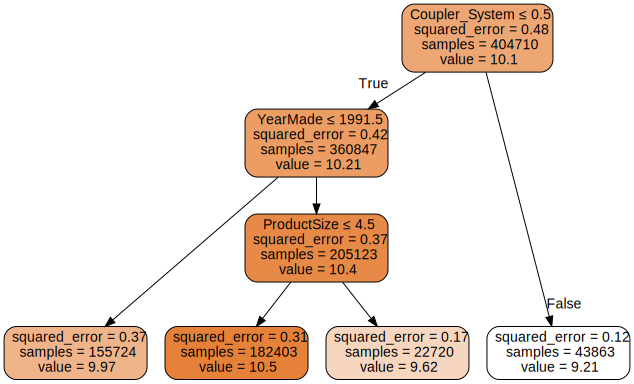

In [ ]:
draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

Understanding this picture is one of the best ways to understand decision trees. Let's start at the top and explain each part step by step:
- The top node represents the *initial model* before any splits have been done, when all the data is in one group. This is the simplest possible model. It is the result of asking zero questions and will always predict the value to be the average value of the whole dataset. In this case, we can see it predicts a value of 10.10 for the logarithm of the sales price. It gives a mean squared error of 0.48. The square root of this is 0.69. (Remember that unless you see `m_rmse`, or a *root mean squared error*, then the value you are looking at is before taking the square root, so it is just the average of the square of the differences.) We can also see that there are 404,710 auction records in this group—that is the total size of our training set. The final piece of information shown here is the decision criterion for the best split that was found, which is to split based on the `coupler_system` column.

- Moving down and to the left, this node shows us that there were 360,847 auction records for equipment where `coupler_system` was less than 0.5. The average value of our dependent variable in this group is 10.21. Moving down and to the right from the initial model takes us to the records where `coupler_system` was greater than 0.5.

- The bottom row contains our *leaf nodes*: the nodes with no answers coming out of them, because there are no more questions to be answered. At the far right of this row is the node containing records where `coupler_system` was greater than 0.5. The average value here is 9.21, so we can see the decision tree algorithm did find a single binary decision that separated high-value from low-value auction results. Asking only about `coupler_system` predicts an average value of 9.21 versus 10.1.

- Returning back to the top node after the first decision point, we can see that a second binary decision split has been made, based on asking whether `YearMade` is less than or equal to 1991.5. For the group where this is true (remember, this is now following two binary decisions, based on `coupler_system` and `YearMade`) the average value is 9.97, and there are 155,724 auction records in this group. For the group of auctions where this decision is false, the average value is 10.4, and there are 205,123 records. So again, we can see that the decision tree algorithm has successfully split our more expensive auction records into two more groups which differ in value significantly.

We can show the same information using Terence Parr's powerful [dtreeviz](https://explained.ai/decision-tree-viz/) library:

In [ ]:
import dtreeviz

def show_dtreeviz(model, X, y, features, target, scale, label_fontsize, orientation):
    viz_model = dtreeviz.model(
        model,
        X_train=X,
        y_train=y,
        target_name=target,
        feature_names=features,
    )
    display(viz_model.view(scale=scale, fontname='DejaVu Sans', label_fontsize=label_fontsize, orientation=orientation))

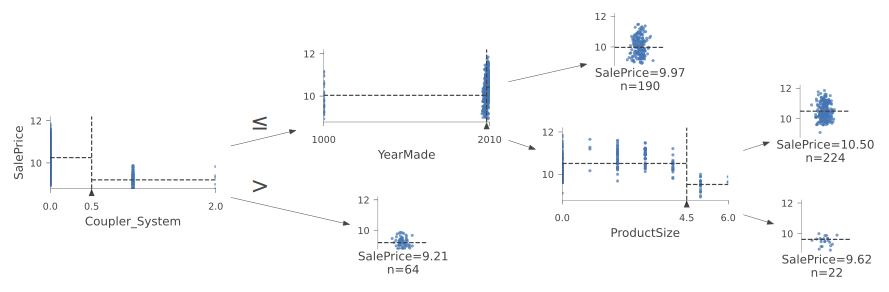

In [ ]:
samp_idx = np.random.permutation(len(y))[:500]
show_dtreeviz(
    m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
    scale=1.6, label_fontsize=10, orientation='LR'
)

This shows a chart of the distribution of the data for each split point. We can clearly see that there's a problem with our `YearMade` data: there are bulldozers made in the year 1000, apparently! Presumably this is actually just a missing value code (a value that doesn't otherwise appear in the data and that is used as a placeholder in cases where a value is missing). For modeling purposes, 1000 is fine, but as you can see this outlier makes visualization of the values we are interested in more difficult. So, let's replace it with 1950:

In [ ]:
xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950

That change makes the split much clearer in the tree visualization, even although it doesn't actually change the result of the model in any significant way. This is a great example of how resilient decision trees are to data issues!

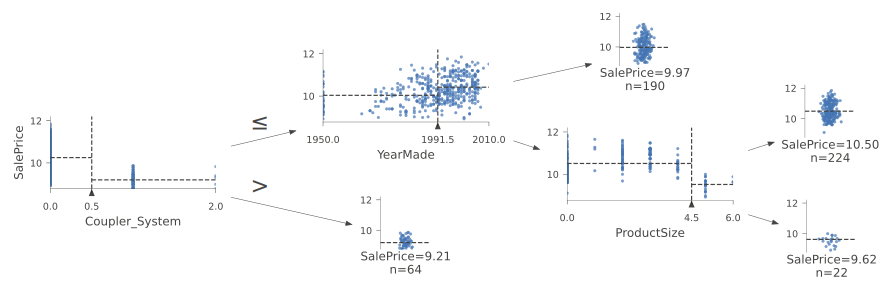

In [ ]:
m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs, y)

show_dtreeviz(
    m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
    scale=1.6, label_fontsize=10, orientation='LR'
)

Let's now have the decision tree algorithm build a bigger tree. Here, we are not passing in any stopping criteria such as `max_leaf_nodes`:

In [ ]:
m = DecisionTreeRegressor()
m.fit(xs, y);

We'll create a little function to check the root mean squared error of our model (`m_rmse`), since that's how the competition was judged:

In [ ]:
def r_mse(pred,y):
    return round(math.sqrt(((pred-y)**2).mean()), 6)

def m_rmse(m, xs, y):
    return r_mse(m.predict(xs), y)

In [ ]:
m_rmse(m, xs, y)

0.0

So, our model is perfect, right? Not so fast... remember we really need to check the validation set, to ensure we're not overfitting:

In [ ]:
m_rmse(m, valid_xs, valid_y)

0.326455

Oops—it looks like we might be overfitting pretty badly. Here's why:

In [ ]:
m.get_n_leaves(), len(xs)

(324560, 404710)

We've got nearly as many leaf nodes as data points! That seems a little over-enthusiastic. Indeed, sklearn's default settings allow it to continue splitting nodes until there is only one item in each leaf node. Let's change the stopping rule to tell sklearn to ensure every leaf node contains at least 25 auction records:

In [ ]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.248582, 0.322975)

That looks much better. Let's check the number of leaves again:

In [ ]:
m.get_n_leaves()

12398

Much more reasonable!

Building a decision tree is a good way to create a model of our data. It is very flexible, since it can clearly handle nonlinear relationships and interactions between variables. But we can see there is a fundamental compromise between how well it generalizes (which we can achieve by creating small trees) and how accurate it is on the training set (which we can achieve by using large trees).

So how do we get the best of both worlds? We'll show you right after we handle an important missing detail: how to handle categorical variables.

Now that you understand how decisions tree work, it's time for the best-of-both-worlds solution: random forests.

## Random Forests

In 1994 Berkeley professor Leo Breiman, one year after his retirement, published a small technical report called ["Bagging Predictors"](https://www.stat.berkeley.edu/~breiman/bagging.pdf), which turned out to be one of the most influential ideas in modern machine learning. The report began:

> Bagging predictors is a method for generating multiple versions of a predictor and using these to get an aggregated predictor. The aggregation averages over the versions... The multiple versions are formed by making bootstrap replicates of the learning set and using these as new learning sets. Tests… show that bagging can give substantial gains in accuracy. The vital element is the instability of the prediction method. If perturbing the learning set can cause significant changes in the predictor constructed, then bagging can improve accuracy.

Here is the procedure that Breiman is proposing:

1. Randomly choose a subset of the rows of your data (i.e., "bootstrap replicates of your learning set").
1. Train a model using this subset.
1. Save that model, and then return to step 1 a few times.
1. This will give you a number of trained models. To make a prediction, predict using all of the models, and then take the average of each of those model's predictions.

This procedure is known as "bagging." It is based on a deep and important insight: although each of the models trained on a subset of data will make more errors than a model trained on the full dataset, those errors will not be correlated with each other. Different models will make different errors. The average of those errors, therefore, is: zero! So if we take the average of all of the models' predictions, then we should end up with a prediction that gets closer and closer to the correct answer, the more models we have. This is an extraordinary result—it means that we can improve the accuracy of nearly any kind of machine learning algorithm by training it multiple times, each time on a different random subset of the data, and averaging its predictions.

In 2001 Leo Breiman went on to demonstrate that this approach to building models, when applied to decision tree building algorithms, was particularly powerful. He went even further than just randomly choosing rows for each model's training, but also randomly selected from a subset of columns when choosing each split in each decision tree. He called this method the *random forest*. Today it is, perhaps, the most widely used and practically important machine learning method.

In essence a random forest is a model that averages the predictions of a large number of decision trees, which are generated by randomly varying various parameters that specify what data is used to train the tree and other tree parameters. Bagging is a particular approach to "ensembling," or combining the results of multiple models together. To see how it works in practice, let's get started on creating our own random forest!

### Creating a Random Forest

In [ ]:
to = load_pickle(path/'to.pkl')
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

We can create a random forest just like we created a decision tree, except now, we are also specifying parameters that indicate how many trees should be in the forest, how we should subset the data items (the rows), and how we should subset the fields (the columns).

In the following function definition `n_estimators` defines the number of trees we want, `max_samples` defines how many rows to sample for training each tree, and `max_features` defines how many columns to sample at each split point (where `0.5` means "take half the total number of columns"). We can also specify when to stop splitting the tree nodes, effectively limiting the depth of the tree, by including the same `min_samples_leaf` parameter we used in the last section. Finally, we pass `n_jobs=-1` to tell sklearn to use all our CPUs to build the trees in parallel. By creating a little function for this, we can more quickly try different variations in the rest of this chapter:

In [ ]:
def rf(xs, y, n_estimators=40, max_samples=200_000, max_features=0.5, min_samples_leaf=5, **kwargs):

    m = RandomForestRegressor(
        n_jobs=-1,
        n_estimators=n_estimators,
        max_samples=max_samples,
        max_features=max_features,
        min_samples_leaf=min_samples_leaf,
        oob_score=True
        )
    m.fit(xs, y)
    return m

In [ ]:
m = rf(xs, y);

Our validation RMSE is now much improved over our last result produced by the `DecisionTreeRegressor`, which made just one tree using all the available data:

In [ ]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.171079, 0.234445)

One of the most important properties of random forests is that they aren't very sensitive to the hyperparameter choices, such as `max_features`.

You can set `n_estimators` to as high a number as you have time to train—the more trees you have, the more accurate the model will be.

`max_samples` can often be left at its default, unless you have over 200,000 data points, in which case setting it to 200,000 will make it train faster with little impact on accuracy.

`max_features=0.5` and `min_samples_leaf=4` both tend to work well, although sklearn's defaults work well too.

To see the impact of `n_estimators`, let's get the predictions from each individual tree in our forest (these are in the `estimators_` attribute):

In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])
preds.shape

(40, 7988)

As you can see, `preds.mean(0)` gives the same results as our random forest:

In [ ]:
r_mse(preds.mean(0), valid_y)

0.234445

Let's see what happens to the RMSE as we add more and more trees. As you can see, the improvement levels off quite a bit after around 30 trees:

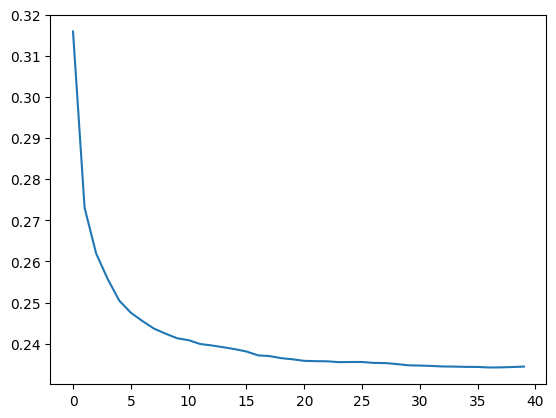

In [ ]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

The performance on our validation set is worse than on our training set. But is that because we're overfitting, or because the validation set covers a different time period, or a bit of both? With the existing information we've seen, we can't tell. However, random forests have a very clever trick called *out-of-bag* (OOB) error that can help us with this (and more!).

### Out-of-Bag Error

Recall that in a random forest, each tree is trained on a different subset of the training data. The OOB error is a way of measuring prediction error on the training set by only including in the calculation of a row's error trees where that row was *not* included in training. This allows us to see whether the model is overfitting, without needing a separate validation set.

> A: My intuition for this is that, since every tree was trained with a different randomly selected subset of rows, out-of-bag error is a little like imagining that every tree therefore also has its own validation set. That validation set is simply the rows that were not selected for that tree's training.

This is particularly beneficial in cases where we have only a small amount of training data, as it allows us to see whether our model generalizes without removing items to create a validation set. The OOB predictions are available in the `oob_prediction_` attribute. Note that we compare them to the training labels, since this is being calculated on trees using the training set.

In [ ]:
r_mse(m.oob_prediction_, y)

0.210903

We can see that our OOB error is much lower than our validation set error. This means that something else is causing that error, in *addition* to normal generalization error. We'll discuss the reasons for this later in this chapter.

This is one way to interpret our model's predictions—let's focus on more of those now.

## Model Interpretation

For tabular data, model interpretation is particularly important. For a given model, the things we are most likely to be interested in are:

- How confident are we in our predictions using a particular row of data?
- For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
- Which columns are the strongest predictors, which can we ignore?
- Which columns are effectively redundant with each other, for purposes of prediction?
- How do predictions vary, as we vary these columns?

As we will see, random forests are particularly well suited to answering these questions. Let's start with the first one!

### Tree Variance for Prediction Confidence

We saw how the model averages the individual tree's predictions to get an overall prediction—that is, an estimate of the value. But how can we know the confidence of the estimate? One simple way is to use the standard deviation of predictions across the trees, instead of just the mean. This tells us the *relative* confidence of predictions. In general, we would want to be more cautious of using the results for rows where trees give very different results (higher standard deviations), compared to cases where they are more consistent (lower standard deviations).

In the earlier section on creating a random forest, we saw how to get predictions over the validation set, using a Python list comprehension to do this for each tree in the forest:

In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [ ]:
preds.shape

(40, 7988)

Now we have a prediction for every tree and every auction (40 trees and 7,988 auctions) in the validation set.

Using this we can get the standard deviation of the predictions over all the trees, for each auction:

In [ ]:
preds_std = preds.std(0)

Here are the standard deviations for the predictions for the first five auctions—that is, the first five rows of the validation set:

In [ ]:
preds_std[:5]

array([0.27553349, 0.10057154, 0.09114166, 0.27120712, 0.10483711])

As you can see, the confidence in the predictions varies widely. For some auctions, there is a low standard deviation because the trees agree. For others it's higher, as the trees don't agree. This is information that would be useful in a production setting; for instance, if you were using this model to decide what items to bid on at auction, a low-confidence prediction might cause you to look more carefully at an item before you made a bid.

### Feature Importance

It's not normally enough just to know that a model can make accurate predictions—we also want to know *how* it's making predictions. *feature importance* gives us insight into this. We can get these directly from sklearn's random forest by looking in the `feature_importances_` attribute. Here's a simple function we can use to pop them into a DataFrame and sort them:

In [ ]:
def rf_feat_importance(m, df):
    imp  =  pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_})
    return imp.sort_values('imp', ascending=False)

The feature importances for our model show that the first few most important columns have much higher importance scores than the rest, with (not surprisingly) `YearMade` and `ProductSize` being at the top of the list:

In [ ]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
57,YearMade,0.178601
30,Coupler_System,0.136875
6,ProductSize,0.114204
7,fiProductClassDesc,0.074511
54,ModelID,0.059849
65,saleElapsed,0.050910
3,fiSecondaryDesc,0.040900
31,Grouser_Tracks,0.031986
1,fiModelDesc,0.031433
12,Enclosure,0.029166


A plot of the feature importances shows the relative importances more clearly:

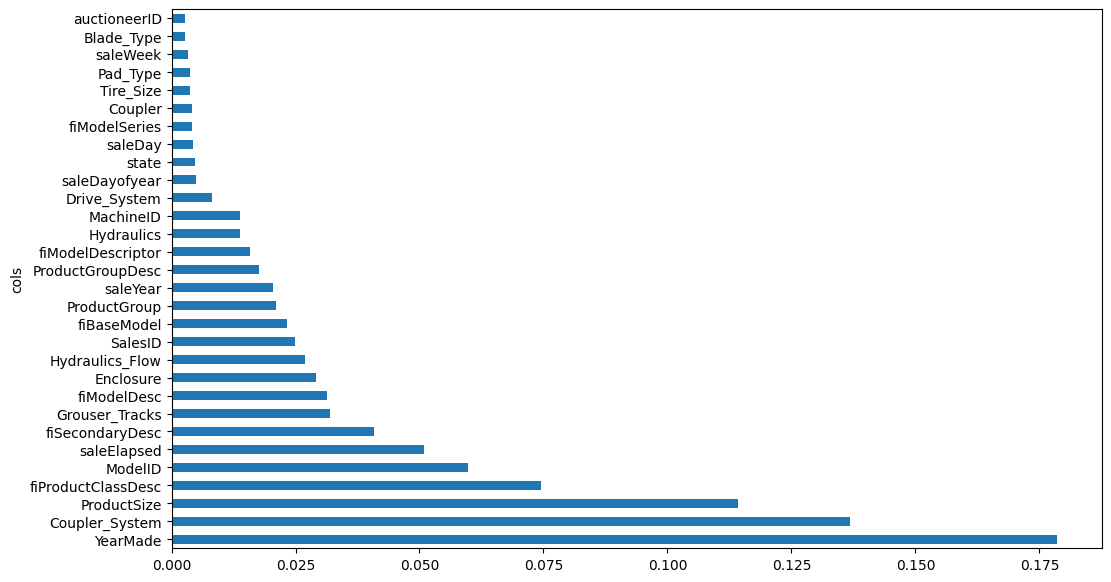

In [ ]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

The way these importances are calculated is quite simple yet elegant. The feature importance algorithm loops through each tree, and then recursively explores each branch. At each branch, it looks to see what feature was used for that split, and how much the model improves as a result of that split. The improvement (weighted by the number of rows in that group) is added to the importance score for that feature. This is summed across all branches of all trees, and finally the scores are normalized such that they add to 1.

### Removing Low-Importance Variables

It seems likely that we could use just a subset of the columns by removing the variables of low importance and still get good results. Let's try just keeping those with a feature importance greater than 0.005:

In [ ]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

20

We can retrain our model using just this subset of the columns:

In [ ]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [ ]:
m = rf(xs_imp, y)

And here's the result:

In [ ]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.181308, 0.231415)

Our accuracy is about the same, but we have far fewer columns to study:

In [ ]:
len(xs.columns), len(xs_imp.columns)

(66, 20)

We've found that generally the first step to improving a model is simplifying it—78 columns was too many for us to study them all in depth! Furthermore, in practice often a simpler, more interpretable model is easier to roll out and maintain.

This also makes our feature importance plot easier to interpret. Let's look at it again:

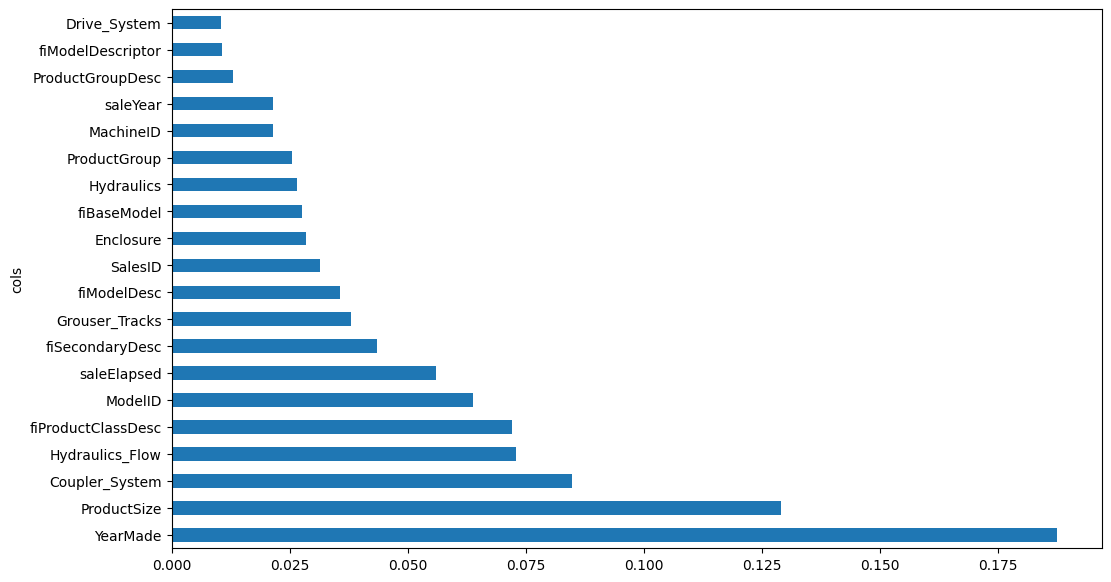

In [ ]:
plot_fi(rf_feat_importance(m, xs_imp));

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings: for example, `ProductGroup` and `ProductGroupDesc`. Let's try to remove any redundent features.

### Removing Redundant Features

Let's start with:

In [ ]:
import scipy
from scipy.cluster import hierarchy as hc

def cluster_columns(df, figsize=(10,6), font_size=12):
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=figsize)
    hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=font_size)
    plt.show()

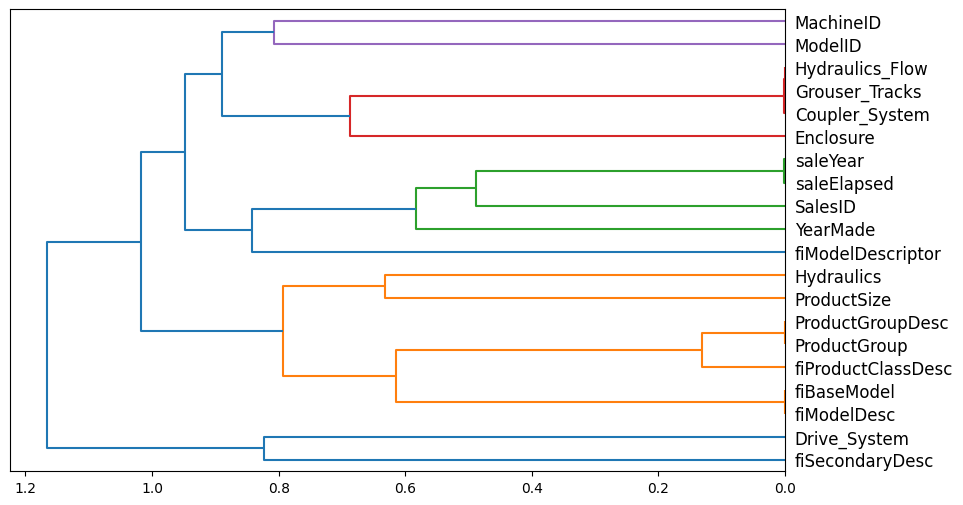

In [ ]:
cluster_columns(xs_imp)

In this chart, the pairs of columns that are most similar are the ones that were merged together early, far from the "root" of the tree at the left. Unsurprisingly, the fields `ProductGroup` and `ProductGroupDesc` were merged quite early, as were `saleYear` and `saleElapsed` and `fiModelDesc` and `fiBaseModel`. These might be so closely correlated they are practically synonyms for each other.


<details>
<summary>More on determining similarity</summary>
<h4>Determining Similarity:</h4>
<p>The most similar pairs are found by calculating the _rank correlation_, which means that all the values are replaced with their _rank_ (i.e., first, second, third, etc. within the column), and then the _correlation_ is calculated.</p>
</details>


Let's try removing some of these closely related features to see if the model can be simplified without impacting the accuracy.

First, we create a function that quickly trains a random forest and returns the OOB score, by using a lower `max_samples` and higher `min_samples_leaf`. The OOB score is a number returned by sklearn that ranges between 1.0 for a perfect model and 0.0 for a random model. We don't need it to be very accurate—we're just going to use it to compare different models, based on removing some of the possibly redundant columns:

In [ ]:
def get_oob(df):
    m = RandomForestRegressor(
        n_estimators=40,
        min_samples_leaf=15,
        max_samples=50000,
        max_features=0.5,
        n_jobs=-1,
        oob_score=True
    )
    m.fit(df, y)
    return m.oob_score_

Here's our baseline:

In [ ]:
get_oob(xs_imp)

0.8771796900066834

Now we try removing each of our potentially redundant variables, one at a time:

In [ ]:
{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
    'saleYear', 'saleElapsed', 'ProductGroupDesc','ProductGroup',
    'fiModelDesc', 'fiBaseModel',
    'Hydraulics_Flow','Grouser_Tracks', 'Coupler_System')}

{'saleYear': 0.8757031055000613,
 'saleElapsed': 0.8720589679431621,
 'ProductGroupDesc': 0.8761898009619611,
 'ProductGroup': 0.8767452191702887,
 'fiModelDesc': 0.8748310533605441,
 'fiBaseModel': 0.8757287489393396,
 'Hydraulics_Flow': 0.8768443305896119,
 'Grouser_Tracks': 0.8765520271449567,
 'Coupler_System': 0.876704493380915}

Now let's try dropping multiple variables. We'll drop one from each of the tightly aligned pairs we noticed earlier. Let's see what that does:

In [ ]:
to_drop = ['saleYear', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks']
get_oob(xs_imp.drop(to_drop, axis=1))

0.8751218515418059

Looking good! This is really not much worse than the model with all the fields. Let's create DataFrames without these columns, and save them:

In [ ]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [ ]:
save_pickle(path/'xs_final.pkl', xs_final)
save_pickle(path/'valid_xs_final.pkl', valid_xs_final)

We can load them back later with:

In [ ]:
xs_final = load_pickle(path/'xs_final.pkl')
valid_xs_final = load_pickle(path/'valid_xs_final.pkl')

Now we can check our RMSE again, to confirm that the accuracy hasn't substantially changed.

In [ ]:
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(0.182654, 0.231832)

By focusing on the most important variables, and removing some redundant ones, we've greatly simplified our model. Now, let's see how those variables affect our predictions using partial dependence plots.

## Extrapolation and Neural Networks

A problem with random forests, like all machine learning or deep learning algorithms, is that they don't always generalize well to new data. We will see in which situations neural networks generalize better, but first, let's look at the extrapolation problem that random forests have.

### The Extrapolation Problem

In [ ]:
np.random.seed(42)

Let's consider the simple task of making predictions from 40 data points showing a slightly noisy linear relationship:

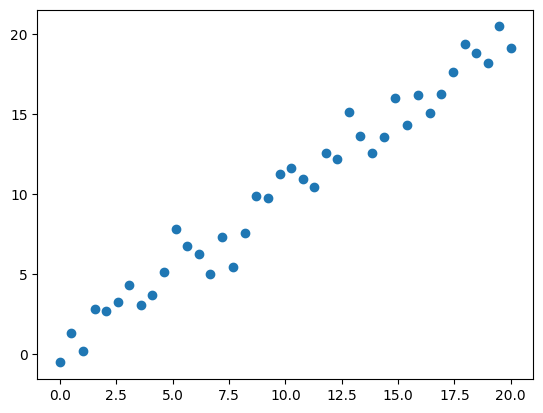

In [ ]:
x_lin = torch.linspace(0,20, steps=40)
y_lin = x_lin + torch.randn_like(x_lin)
plt.scatter(x_lin, y_lin);

Although we only have a single independent variable, sklearn expects a matrix of independent variables, not a single vector. So we have to turn our vector into a matrix with one column. In other words, we have to change the *shape* from `[40]` to `[40,1]`. One way to do that is with the `unsqueeze` method, which adds a new unit axis to a tensor at the requested dimension:

In [ ]:
xs_lin = x_lin.unsqueeze(1)
x_lin.shape, xs_lin.shape

(torch.Size([40]), torch.Size([40, 1]))

A more flexible approach is to slice an array or tensor with the special value `None`, which introduces an additional unit axis at that location:

In [ ]:
x_lin[:, None].shape

torch.Size([40, 1])

We can now create a random forest for this data. We'll use only the first 30 rows to train the model:

In [ ]:
m_lin = RandomForestRegressor().fit(xs_lin[:30],y_lin[:30])

Then we'll test the model on the full dataset. The blue dots are the training data, and the red dots are the predictions:

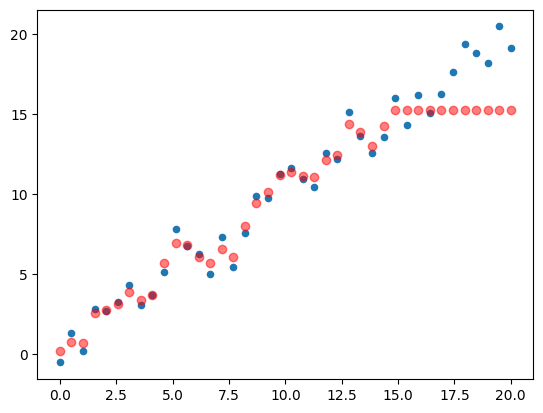

In [ ]:
plt.scatter(x_lin, y_lin, 20)
plt.scatter(x_lin, m_lin.predict(xs_lin), color='red', alpha=0.5);

We have a big problem! Our predictions outside of the domain that our training data covered are all too low. Why do you suppose this is?

Remember, a random forest just averages the predictions of a number of trees. And a tree simply predicts the average value of the rows in a leaf. Therefore, a tree and a random forest can never predict values outside of the range of the training data. This is particularly problematic for data where there is a trend over time, such as inflation, and you wish to make predictions for a future time. Your predictions will be systematically too low.

But the problem extends beyond time variables. Random forests are not able to extrapolate outside of the types of data they have seen, in a more general sense. That's why we need to make sure our validation set does not contain out-of-domain data.

### Finding Out-of-Domain Data

Sometimes it is hard to know whether your test set is distributed in the same way as your training data, or, if it is different, what columns reflect that difference. There's actually an easy way to figure this out, which is to use a random forest!

But in this case we don't use the random forest to predict our actual dependent variable. Instead, we try to predict whether a row is in the validation set or the training set. To see this in action, let's combine our training and validation sets together, create a dependent variable that represents which dataset each row comes from, build a random forest using that data, and get its feature importance:

In [ ]:
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:6]

,cols,imp
5,saleElapsed,0.909283
10,SalesID,0.073519
14,MachineID,0.014788
0,YearMade,0.000487
4,ModelID,0.000467
6,fiSecondaryDesc,0.000432


This shows that there are three columns that differ significantly between the training and validation sets: `saleElapsed`, `SalesID`, and `MachineID`. It's fairly obvious why this is the case for `saleElapsed`: it's the number of days between the start of the dataset and each row, so it directly encodes the date. The difference in `SalesID` suggests that identifiers for auction sales might increment over time. `MachineID` suggests something similar might be happening for individual items sold in those auctions.

Let's get a baseline of the original random forest model's RMSE, then see what the effect is of removing each of these columns in turn:

In [ ]:
m = rf(xs_final, y)
print('orig', m_rmse(m, valid_xs_final, valid_y))

for c in ('SalesID','saleElapsed','MachineID'):
    m = rf(xs_final.drop(c,axis=1), y)
    print(c, m_rmse(m, valid_xs_final.drop(c,axis=1), valid_y))

orig 0.233443
SalesID 0.230186
saleElapsed 0.235828
MachineID 0.231307


It looks like we should be able to remove `SalesID` and `MachineID` without losing any accuracy. Let's check:

In [ ]:
time_vars = ['SalesID','MachineID']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

m = rf(xs_final_time, y)
m_rmse(m, valid_xs_time, valid_y)

0.229145

Removing these variables has slightly improved the model's accuracy; but more importantly, it should make it more resilient over time, and easier to maintain and understand. We recommend that for all datasets you try building a model where your dependent variable is `is_valid`, like we did here. It can often uncover subtle *domain shift* issues that you may otherwise miss.

One thing that might help in our case is to simply avoid using old data. Often, old data shows relationships that just aren't valid any more. Let's try just using the most recent few years of the data:

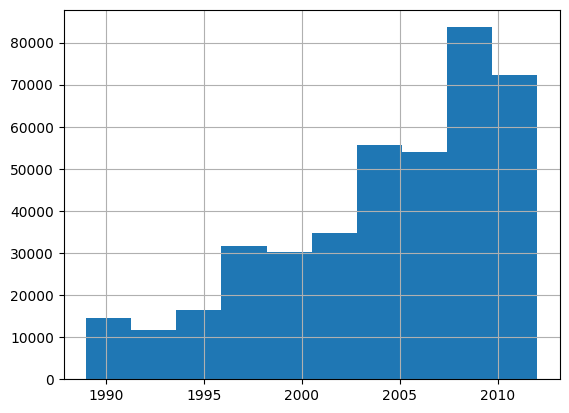

In [ ]:
xs['saleYear'].hist();

Here's the result of training on this subset:

In [ ]:
filt = xs['saleYear']>2004
xs_filt = xs_final_time[filt]
y_filt = y[filt]

In [ ]:
m = rf(xs_filt, y_filt)
m_rmse(m, xs_filt, y_filt), m_rmse(m, valid_xs_time, valid_y)

(0.176976, 0.229064)

It's a tiny bit better, which shows that you shouldn't always just use your entire dataset; sometimes a subset can be better.

Let's see if using a neural network helps.

### Using a Neural Network

We can use the same approach to build a neural network model. Let's first replicate the steps we took to set up the `TabularPandas` object:

In [ ]:
df_nn = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
df_nn['ProductSize'] = df_nn['ProductSize'].cat.set_categories(sizes, ordered=True)
df_nn[dep_var] = np.log(df_nn[dep_var])
df_nn = add_datepart(df_nn, 'saledate')

We can leverage the work we did to trim unwanted columns in the random forest by using the same set of columns for our neural network:

In [ ]:
df_nn_final = df_nn[list(xs_final_time.columns) + [dep_var]]

Categorical columns are handled very differently in neural networks, compared to decision tree approaches. As we saw in `Chapter 8 Collab`, in a neural net a great way to handle categorical variables is by using embeddings. To create embeddings, fastai needs to determine which columns should be treated as categorical variables. It does this by comparing the number of distinct levels in the variable to the value of the `max_card` parameter. If it's lower, fastai will treat the variable as categorical. Embedding sizes larger than 10,000 should generally only be used after you've tested whether there are better ways to group the variable, so we'll use 9,000 as our `max_card`:

In [ ]:
cont_nn, cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

In this case, there's one variable that we absolutely do not want to treat as categorical: the `saleElapsed` variable. A categorical variable cannot, by definition, extrapolate outside the range of values that it has seen, but we want to be able to predict auction sale prices in the future. Let's verify that `cont_cat_split` did the correct thing.

In [ ]:
cont_nn

['saleElapsed']

Let's take a look at the cardinality of each of the categorical variables that we have chosen so far:

In [ ]:
df_nn_final[cat_nn].nunique()

YearMade                73
Coupler_System           2
ProductSize              6
fiProductClassDesc      74
ModelID               5281
fiSecondaryDesc        177
fiModelDesc           5059
Enclosure                6
Hydraulics_Flow          3
ProductGroup             6
fiModelDescriptor      140
Hydraulics              12
Drive_System             4
dtype: int64

The fact that there are two variables pertaining to the "model" of the equipment, both with similar very high cardinalities, suggests that they may contain similar, redundant information. Note that we would not necessarily see this when analyzing redundant features, since that relies on similar variables being sorted in the same order (that is, they need to have similarly named levels). Having a column with 5,000 levels means needing 5,000 columns in our embedding matrix, which would be nice to avoid if possible. Let's see what the impact of removing one of these model columns has on the random forest:

In [ ]:
xs_filt2 = xs_filt.drop('fiModelDescriptor', axis=1)
valid_xs_time2 = valid_xs_time.drop('fiModelDescriptor', axis=1)
m2 = rf(xs_filt2, y_filt)
m_rmse(m2, xs_filt2, y_filt), m_rmse(m2, valid_xs_time2, valid_y)

(0.178991, 0.230083)

There's minimal impact, so we will remove it as a predictor for our neural network:

In [ ]:
cat_nn.remove('fiModelDescriptor')

We can create our `TabularPandas` object in the same way as when we created our random forest, with one very important addition: normalization. A random forest does not need any normalization—the tree building procedure cares only about the order of values in a variable, not at all about how they are scaled. But as we have seen, a neural network definitely does care about this. Therefore, we add the `Normalize` processor when we build our `TabularPandas` object:

In [ ]:
procs_nn = [Categorify, FillMissing, Normalize]

to_nn = TabularPandas(
    df=df_nn_final,
    procs=procs_nn,
    cat_names=cat_nn,
    cont_names=cont_nn,
    splits=splits,
    y_names=dep_var
)

Now we need to provide the fastai package a recipe about how data needs to be presented to the model.

In the case of tabular models and data don't generally require much GPU RAM, so we can use larger batch sizes:

In [ ]:
dls = to_nn.dataloaders(1024)

As we've discussed, it's a good idea to set `y_range` for regression models, so let's find the min and max of our dependent variable:

In [ ]:
y = to_nn.train.y
y.min(), y.max()

(8.465899, 11.863583)

We can now create the `Learner` to create this tabular model. As usual, we use the application-specific learner function, to take advantage of its application-customized defaults. We set the loss function to MSE, since that's what this competition uses.

By default, for tabular data fastai creates a neural network with two hidden layers, with 200 and 100 activations, respectively. This works quite well for small datasets, but here we've got quite a large dataset, so we increase the layer sizes to 500 and 250:

In [ ]:
learn = tabular_learner(
    dls=dls,
    y_range=(8,12),
    layers=[500,250],
    n_out=1,
    loss_func=F.mse_loss
)

SuggestedLRs(valley=0.00019054606673307717)

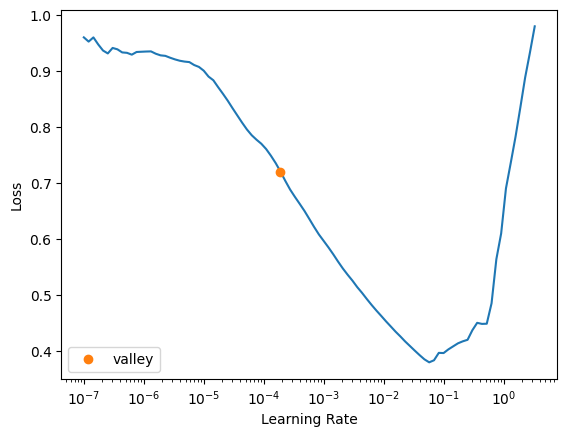

In [ ]:
lr = learn.lr_find()
lr

With tabulare data, we do not use pretrained models. All models are trained from stratch. Therefore, we do not use `fine_tune`, but `fit_one_cycle`. We will run for a few epochs and see how it looks:

In [ ]:
learn.fit_one_cycle(n_epoch=10, lr_max=lr.valley)

epoch,train_loss,valid_loss,time
0,0.072191,0.076366,00:06
1,0.054590,0.071925,00:11
2,0.048084,0.060141,00:04
3,0.044806,0.055095,00:04
4,0.042134,0.055952,00:05
5,0.040776,0.061359,00:04
6,0.038219,0.054786,00:04
7,0.037179,0.051887,00:05
8,0.035937,0.052185,00:04
9,0.035861,0.052046,00:05


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

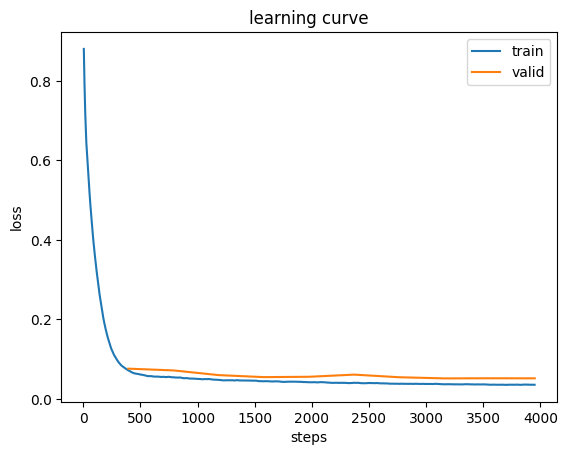

In [ ]:
learn.recorder.plot_loss()

We can use our `r_mse` function to compare the result to the random forest result we got earlier:

In [ ]:
preds, targs = learn.get_preds()
r_mse(preds,targs)

0.228136

It's quite a bit better than the random forest (although it took longer to train, and it's fussier about hyperparameter tuning).

Before we move on, let's save our model in case we want to come back to it again later:

In [ ]:
learn.save('nn')

Path('models/nn.pth')

Another thing that can help with generalization is to use several models and average their predictions—a technique, as mentioned earlier, known as *ensembling*.

## Conclusion: Our Advice for Tabular Modeling

We have dicussed two approaches to tabular modeling: decision tree ensembles and neural networks. We've also mentioned two different decision tree ensembles: random forests, and gradient boosting machines. Each is very effective, but each also has compromises:

- *Random forests* are the easiest to train, because they are extremely resilient to hyperparameter choices and require very little preprocessing. They are very fast to train, and should not overfit if you have enough trees. But they can be a little less accurate, especially if extrapolation is required, such as predicting future time periods.

- *Gradient boosting machines* in theory are just as fast to train as random forests, but in practice you will have to try lots of different hyperparameters. They can overfit, but they are often a little more accurate than random forests.

- *Neural networks* take the longest time to train, and require extra preprocessing, such as normalization; this normalization needs to be used at inference time as well. They can provide great results and extrapolate well, but only if you are careful with your hyperparameters and take care to avoid overfitting.

We suggest starting your analysis with a random forest. This will give you a strong baseline, and you can be confident that it's a reasonable starting point. You can then use that model for feature selection and partial dependence analysis, to get a better understanding of your data.

From that foundation, you can try neural nets and GBMs, and if they give you significantly better results on your validation set in a reasonable amount of time, you can use them. If decision tree ensembles are working well for you, try adding the embeddings for the categorical variables to the data, and see if that helps your decision trees learn better.